In [1]:
import pandas as pd

dados = pd.read_csv('../dados/CSV_Completo.csv')

animal = 'É animal mais atropelado'
animalEscolhido = 'rã-manteiga'

dados.loc[dados.Animal == animalEscolhido,animal] = 1
dados.loc[dados.Animal != animalEscolhido,animal] = 0


dados[animal] = dados[animal].astype(int)

del(dados['Animal'])
del(dados['Km'])
del(dados['Hora da Coleta'])


In [2]:
from collections import OrderedDict

categorias = {}
# categorias['Mês'] = dados['Mês']

for i in dados:
      categorias[i] = dados[i]
      # categorias[i] = i
      

for feature in categorias:
  categorias[feature] = list(OrderedDict.fromkeys(categorias[feature]))
  
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for i in dados:
    dados[i] = le.fit_transform(dados[i])
    
# print(dados)

categorias_cod = {}

for i in dados:
    categorias_cod[i] = dados[i]
    
for feature in categorias_cod:
  categorias_cod[feature] = list(OrderedDict.fromkeys(categorias_cod[feature]))
  
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13096 entries, 0 to 13095
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   Mês                       13096 non-null  int64
 1   Estação                   13096 non-null  int32
 2   Trecho                    13096 non-null  int64
 3   Sentido                   13096 non-null  int32
 4   Trecho macro              13096 non-null  int32
 5   Tipo De Pistas            13096 non-null  int32
 6   Numero de Pistas          13096 non-null  int32
 7   Tipo de Pavimento         13096 non-null  int32
 8   Numero de Faixas          13096 non-null  int32
 9   Velocidade Maxima         13096 non-null  int32
 10  Tipo da Chuva             13096 non-null  int32
 11  Intervencao               13096 non-null  int32
 12  Vazamento                 13096 non-null  int32
 13  Agua?                     13096 non-null  int32
 14  Vegetação Baixa?          13096 non-nu

0    12915
1      181
Name: É animal mais atropelado, dtype: int64


<BarContainer object of 2 artists>

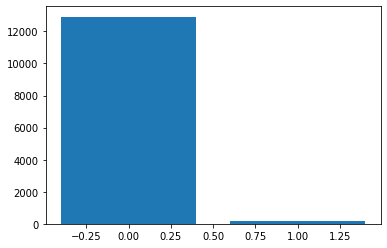

In [3]:
X = dados.iloc[:,:-1]
y = dados.iloc[:,-1]

import matplotlib.pyplot as plt

count = dados[animal].value_counts()
print(count)
plt.bar([0, 1], count) 

In [4]:
cod_cat = {}

for feature in categorias:
  cod_cat[feature] = {}
  for index, cat in enumerate(categorias[feature]):
    cods = categorias_cod[feature]
    cod_cat[feature].update({cods[index]:cat})


Escolhendo as 10 melhores features

In [5]:
from sklearn.feature_selection import SelectKBest, f_regression,  chi2

features = []
for i in X:
    features.append(i)

k = 8 # seleciona 8 features

sel_chi2 = SelectKBest(chi2, k = 8)

X_train_novo = sel_chi2.fit_transform(X, y)

print("os atributos escolhidos foram:")
atributosSelect = []
for j in sel_chi2.get_support(indices=True):
    atributosSelect.append(features[j])
    
print(atributosSelect)

colums = [animal]
col2 = []
for i in range(k):
    colums.append(i)
    col2.append(i)

print(X_train_novo.shape)

novoDf = pd.DataFrame(X_train_novo, y).reset_index()
novoDf.columns = [colums]

novoX = novoDf[col2]
novoY = novoDf[animal]


os atributos escolhidos foram:
['Mês', 'Estação', 'Trecho', 'Numero de Pistas', 'Numero de Faixas', 'Velocidade Maxima', 'Local', 'Faixa de Quilometragem']
(13096, 8)


<BarContainer object of 2 artists>

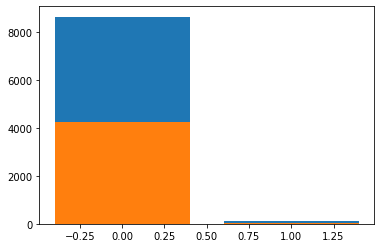

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split

dadosTreino, dadosTeste = train_test_split(novoDf, test_size = 0.33, random_state = 0)

countTreino = dadosTreino[animal].value_counts()

countTeste = dadosTeste[animal].value_counts()

plt.bar([0, 1], countTreino) 
plt.bar([0, 1], countTeste) 

In [7]:
treino_y = dadosTreino.pop(animal)
treino_x = dadosTreino

teste_y = dadosTeste.pop(animal)
teste_x = dadosTeste


In [8]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(treino_x, treino_y)

In [9]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10, max_depth=4, criterion="entropy")

clf_model = clf.fit(X_res, y_res)

y_predict = clf.predict(teste_x)

score = clf_model.score(teste_x,teste_y)
print(score)

0.7889865802869042


C:\Users\rayss\AppData\Local\Temp\ipykernel_11752\3005428260.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_model = clf.fit(X_res, y_res)


              precision    recall  f1-score   support

           0       1.00      0.79      0.88      4270
           1       0.04      0.73      0.08        52

    accuracy                           0.79      4322
   macro avg       0.52      0.76      0.48      4322
weighted avg       0.98      0.79      0.87      4322

Matriz de confusão


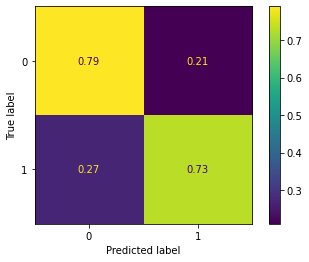

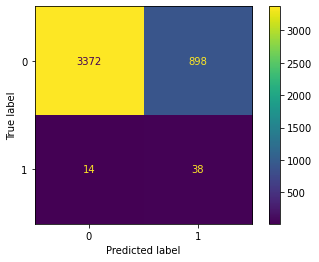

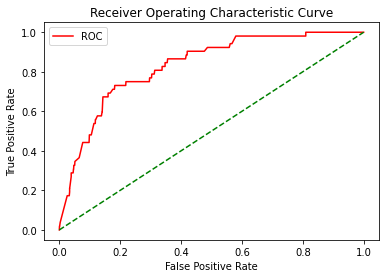

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

print(classification_report(teste_y, y_predict, zero_division=0))
y_true = teste_y

print("Matriz de confusão")
matriz_confusaoPorc = confusion_matrix(y_true, y_predict, normalize = 'true')
matrizPorc = ConfusionMatrixDisplay(matriz_confusaoPorc)
matrizPorc.plot()

matriz_confusao = confusion_matrix(y_true, y_predict)
matriz = ConfusionMatrixDisplay(matriz_confusao)
matriz.plot()
plt.show()

def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
    
from sklearn.metrics import roc_curve

TargetVarScore = clf.predict_proba(teste_x)
fper, tper, thresholds = roc_curve(teste_y, TargetVarScore[:, 1])
plot_roc_curve(fper, tper)

In [11]:
import numpy
from sklearn.model_selection import train_test_split
# from sklearn import metrics, datasets, ensemble

def print_decision_rules(rf):

    for tree_idx, est in enumerate(rf.estimators_):
        tree = est.tree_
        assert tree.value.shape[1] == 1 # no support for multi-output

        print('TREE: {}'.format(tree_idx))

        iterator = enumerate(zip(tree.children_left, tree.children_right, tree.feature, tree.threshold, tree.value))
        for node_idx, data in iterator:
            left, right, feature, th, value = data

            # left: index of left child (if any)
            # right: index of right child (if any)
            # feature: index of the feature to check
            # th: the threshold to compare against
            # value: values associated with classes            

            # for classifier, value is 0 except the index of the class to return
            class_idx = numpy.argmax(value[0])

            if left == -1 and right == -1:
                print('{} LEAF: return class={}'.format(node_idx, class_idx))
            else:
                print('{} NODE: if feature[{}] < {} then next={} else next={}'.format(node_idx, feature, th, left, right))    



# digits = datasets.load_digits()
# Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target)
# estimator = ensemble.RandomForestClassifier(n_estimators=3, max_depth=2)
# estimator.fit(Xtrain, ytrain)

print_decision_rules(clf_model)

TREE: 0
0 NODE: if feature[6] < 8.5 then next=1 else next=16
1 NODE: if feature[0] < 8.5 then next=2 else next=9
2 NODE: if feature[7] < 2.5 then next=3 else next=6
3 NODE: if feature[1] < 1.5 then next=4 else next=5
4 LEAF: return class=0
5 LEAF: return class=1
6 NODE: if feature[1] < 1.5 then next=7 else next=8
7 LEAF: return class=0
8 LEAF: return class=0
9 NODE: if feature[7] < 2.5 then next=10 else next=13
10 NODE: if feature[5] < 12.5 then next=11 else next=12
11 LEAF: return class=1
12 LEAF: return class=1
13 NODE: if feature[2] < 9.0 then next=14 else next=15
14 LEAF: return class=0
15 LEAF: return class=1
16 NODE: if feature[0] < 8.5 then next=17 else next=24
17 NODE: if feature[6] < 9.5 then next=18 else next=21
18 NODE: if feature[2] < 10.5 then next=19 else next=20
19 LEAF: return class=0
20 LEAF: return class=0
21 NODE: if feature[0] < 0.5 then next=22 else next=23
22 LEAF: return class=0
23 LEAF: return class=0
24 NODE: if feature[7] < 1.5 then next=25 else next=28
25 NOD